# Macro Directional (ETF)

Asset Classes: Commodities, REITs, Bonds, Equity Indices, and Bitcoin

## Import Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
from pandas.tseries.offsets import BDay
import pandas_datareader as wb

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import datetime as dt

## Retrieve Data

In [2]:
# define tickers
equities = 'SPY QQQ DIA XLY XLV XLP MCHI VWO VIG ARKK ESGU MTUM'.split()
bonds = 'AGG BND BNDX EMB HYG IEF IEI IGSB LQD SHY TIP TLT'.split()
reits = 'VNQ VNQI'.split()
commods = 'GLD SLV XLE'.split()
crypto = 'BITO'.split()
tickers = equities + bonds + reits + commods + crypto
len(tickers)

30

In [3]:
%%time
data = wb.DataReader(name=tickers, data_source='yahoo', start='2003-01-01', end=dt.date.today())['Adj Close']
data.loc[data.index[-1]+BDay(1),:] = np.nan

Wall time: 31.6 s


## Visualize Time-Series

### Bond ETFs

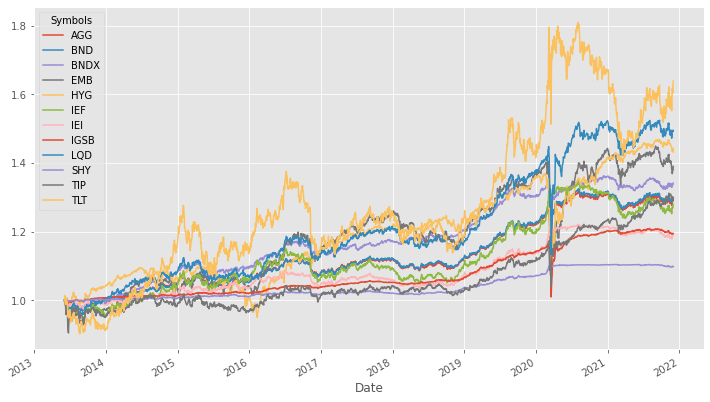

In [4]:
bonds_data = data[[col for col in data.columns if col in bonds]].copy().dropna()
(bonds_data / bonds_data.iloc[0]).plot(figsize=(12,7))
plt.show()

### Non-Bond ETFs

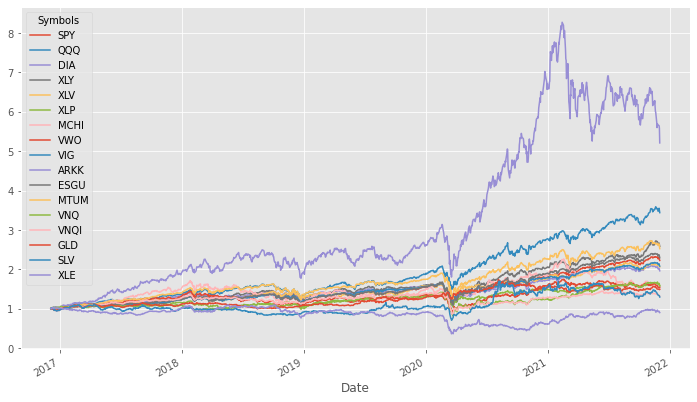

In [5]:
other_data = data[[col for col in data.columns if (col in commods) or (col in reits) or (col in equities)]].copy().dropna()
(other_data / other_data.iloc[0]).plot(figsize=(12,7))
plt.show()

## Set Parameters and Dates

In [6]:
# strategy parameters
lookback = 12
hold = 3
seasonality = None
post_exdate = 1

threshold = 0.90
max_assets = 15
min_assets = 10

# resample dates to monthly timeframe
critical = data.resample('BMS').mean().index
while [date for date in critical if date not in data.index] != []:
    critical = [date if date in data.index else date+BDay(1) for date in critical]
critical = critical[seasonality:]
    
# capture lookback start dates
start = critical[:-lookback:hold]

# capture rebalance dates (after ex-date)
rebalance_on = critical[lookback::hold]
rebalance_on = [date+BDay(post_exdate) for date in rebalance_on]

# capture end of holding dates (on ex-date)
hold_until = [date+BDay(post_exdate)-BDay(1) for date in critical[lookback+hold::hold]]

# capture lookback end dates
end = [date-BDay(1) for date in rebalance_on]

# check sample of lookback and allocation period
i = 71
print(f"Lookback starts : {start[i].date()}")
print(f"Lookback ends   : {end[i].date()}")
print(f"Rebalance on    : {rebalance_on[i].date()}")
print(f"Hold until      : {hold_until[i].date()}")

Lookback starts : 2020-09-01
Lookback ends   : 2021-09-01
Rebalance on    : 2021-09-02
Hold until      : 2021-12-01


## Create Allocation DataFrame

In [7]:
# prepare allocation dataframe
allocation = data.copy()
allocation.loc[:] = np.nan

# loop over rebalancing period
for i in range(len(rebalance_on)):
    
    # define dates for ease of reference
    start_look = start[i]
    end_look = end[i]
    rebal_on = rebalance_on[i]
    try: hold_till = hold_until[i]
    except: hold_till = None
    
    # slice lookback window and drop incomplete dataset
    df = data.loc[start_look:end_look].dropna(axis=1, how='any')
    
    # exclude SPY
    try: df.drop('SPY', axis=1, inplace=True)
    except: pass
    
    # capture maximum and last price during lookback period
    max_price = df.max()
    last_price = df.iloc[-1]
    ratio = last_price / max_price
    
    # select long candidates
    long_names = last_price[last_price > (threshold * max_price)].index.tolist()
    long_names = ratio[long_names].nlargest(max_assets).index.tolist()
    
    # define conditions for long trades
    if len(long_names) >= min_assets:
        
        print(f"Lookback starts : {start_look.date()}")
        print(f"Lookback ends   : {end_look.date()}")
        print(f"Hold from       : {rebal_on.date()}")
        if hold_till is not None:
            print(f"Hold until      : {hold_till.date()}")
        else: pass
        print(f"Long names ({len(long_names)}) : {', '.join(long_names)}")
        print('==========================================')
        
        # allocate capital equally
        allocation.loc[rebal_on:hold_till, long_names] = 1 / len(long_names)

Lookback starts : 2003-03-03
Lookback ends   : 2004-03-01
Hold from       : 2004-03-02
Hold until      : 2004-06-01
Long names (10) : XLP, IEF, XLE, LQD, SHY, XLY, DIA, XLV, QQQ, TLT
Lookback starts : 2003-12-01
Lookback ends   : 2004-12-01
Hold from       : 2004-12-02
Hold until      : 2005-03-01
Long names (11) : QQQ, DIA, XLY, SHY, AGG, LQD, IEF, XLE, TLT, XLP, XLV
Lookback starts : 2004-03-01
Lookback ends   : 2005-03-01
Hold from       : 2005-03-02
Hold until      : 2005-06-01
Long names (12) : DIA, XLP, SHY, AGG, TIP, LQD, IEF, XLE, XLV, XLY, TLT, QQQ
Lookback starts : 2004-06-01
Lookback ends   : 2005-06-01
Hold from       : 2005-06-02
Hold until      : 2005-09-01
Long names (12) : AGG, IEF, SHY, TIP, TLT, LQD, XLV, XLP, DIA, QQQ, XLE, XLY
Lookback starts : 2004-09-01
Lookback ends   : 2005-09-01
Hold from       : 2005-09-02
Hold until      : 2005-12-01
Long names (12) : AGG, SHY, XLE, TIP, IEF, LQD, TLT, XLV, XLP, QQQ, DIA, XLY
Lookback starts : 2004-12-01
Lookback ends   : 200

Lookback starts : 2019-09-03
Lookback ends   : 2020-09-01
Hold from       : 2020-09-02
Hold until      : 2020-12-01
Long names (15) : QQQ, XLY, MCHI, ARKK, ESGU, MTUM, IGSB, TIP, SHY, VIG, XLP, IEI, EMB, BNDX, HYG
Lookback starts : 2019-12-02
Lookback ends   : 2020-12-01
Hold from       : 2020-12-02
Hold until      : 2021-03-01
Long names (15) : QQQ, XLY, ARKK, ESGU, MTUM, EMB, HYG, IGSB, SHY, VIG, TIP, LQD, BNDX, VWO, DIA
Lookback starts : 2020-03-02
Lookback ends   : 2021-03-01
Hold from       : 2021-03-02
Hold until      : 2021-06-01
Long names (15) : SHY, IGSB, HYG, VNQI, VIG, ESGU, DIA, XLE, IEI, BNDX, TIP, AGG, VNQ, BND, XLV
Lookback starts : 2020-06-01
Lookback ends   : 2021-06-01
Hold from       : 2021-06-02
Hold until      : 2021-09-01
Long names (15) : HYG, TIP, VNQ, VNQI, SHY, IGSB, DIA, ESGU, XLE, XLP, VIG, IEI, EMB, XLV, VWO
Lookback starts : 2020-09-01
Lookback ends   : 2021-09-01
Hold from       : 2021-09-02
Hold until      : 2021-12-01
Long names (15) : QQQ, EMB, HYG, V

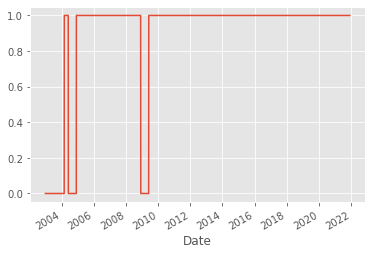

In [8]:
allocation.sum(axis=1).plot(); plt.show() # long-only

## Backtest Strategy

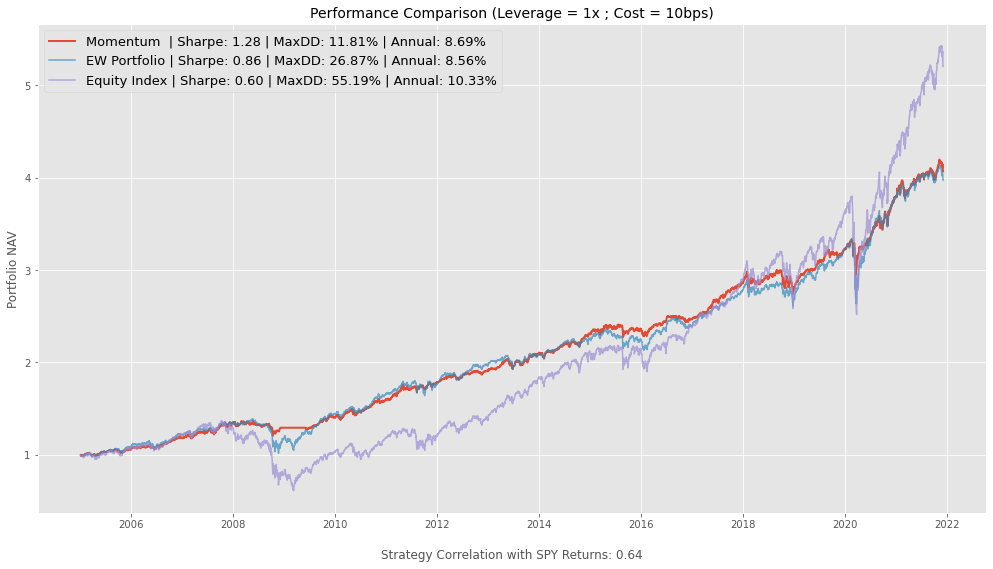

In [9]:
# set trading cost (in bps)
tc = 10
leverage = 1
start_test = '2005'
end_test = None

# calculate daily portfolio return
strat = (data.pct_change() * allocation.shift(2) * leverage).sum(axis=1).loc[start_test:end_test]
bench = data.loc[start_test:end_test,'SPY'].pct_change()
equal = data.loc[start_test:end_test].pct_change().mean(axis=1)

# deduct transaction cost
cost = tc / 10000
turnover = (allocation * leverage).diff().shift().fillna(0).abs()
strat = strat - (turnover * cost).sum(axis=1)

# functionalize Sharpe ratio
def sharpe(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

# functionalize maximum drawdown
def max_dd(daily_return):
    roll_max = (daily_return + 1).cumprod().expanding().max()
    daily_dd = (daily_return + 1).cumprod() / roll_max.values - 1.0
    max_dd = daily_dd.abs().max() * 100
    return max_dd

# functionalize annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

# plot PnL
plt.figure(figsize=(17,9))
plt.plot((strat + 1).cumprod(), label=f"Momentum  | Sharpe: {sharpe(strat):.2f} | MaxDD: {max_dd(strat):.2f}% | Annual: {annualized_return(strat):.2f}%", lw=2)
plt.plot((equal + 1).cumprod(), label=f"EW Portfolio | Sharpe: {sharpe(equal):.2f} | MaxDD: {max_dd(equal):.2f}% | Annual: {annualized_return(equal):.2f}%", alpha=0.7)
plt.plot((bench + 1).cumprod(), label=f"Equity Index | Sharpe: {sharpe(bench):.2f} | MaxDD: {max_dd(bench):.2f}% | Annual: {annualized_return(bench):.2f}%", alpha=0.7)
plt.title(f'Performance Comparison (Leverage = {leverage}x ; Cost = {tc}bps)', fontsize=14)
plt.xlabel(f"\nStrategy Correlation with SPY Returns: {strat.corr(data['SPY'].pct_change()):.2f}", fontsize=12)
plt.ylabel('Portfolio NAV', fontsize=12)
plt.legend(fontsize=13)
plt.show()

# save return to csv file
#strat.to_csv('macro_momentum_return.csv')

## Annual Returns Distribution

In [10]:
strat.dropna().resample('A').sum() * 100

Date
2005-12-31    5.546
2006-12-31   11.770
2007-12-31   12.975
2008-12-31   -3.595
2009-12-31    8.034
2010-12-31   13.670
2011-12-31   11.143
2012-12-31    6.863
2013-12-31    9.892
2014-12-31    8.998
2015-12-31    2.365
2016-12-31    4.798
2017-12-31   14.843
2018-12-31   -1.084
2019-12-31   13.636
2020-12-31   17.241
2021-12-31    6.937
Freq: A-DEC, dtype: float64

## Allocation Distribution

In [11]:
try:
    dist = pd.concat([allocation.loc[rebalance_on[-5]],
                      allocation.loc[rebalance_on[-4]],
                      allocation.loc[rebalance_on[-3]],
                      allocation.loc[rebalance_on[-2]],
                      allocation.loc[rebalance_on[-1]]], axis=1).replace(np.nan, '')
except:
    dist = pd.concat([allocation.loc[rebalance_on[-5]],
                      allocation.loc[rebalance_on[-4]],
                      allocation.loc[rebalance_on[-3]],
                      allocation.loc[rebalance_on[-2]],
                      allocation.iloc[-1]], axis=1).replace(np.nan, '')

dist.sort_index()

,2020-12-02,2021-03-02,2021-06-02,2021-09-02,2021-12-02
Symbols,,,,,
AGG,,0.067,,0.067,0.067
ARKK,0.067,,,,
BITO,,,,,
BND,,0.067,,,0.067
BNDX,0.067,0.067,,,0.067
DIA,0.067,0.067,0.067,0.067,
EMB,0.067,,0.067,0.067,0.067
ESGU,0.067,0.067,0.067,0.067,
GLD,,,,,


# The End